In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc

In [2]:
# just making jupyter wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

### Useful Constants, Setup, etc.

In [58]:
# list of US states
state_names = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
               "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
               "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
               "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

# function for pulling out states
isState = np.vectorize(lambda x: x in state_names)

# set plotsize and style
plt.rcParams['figure.figsize'] = 16, 5
mpl.style.use('ggplot')

### Load Data

In [20]:
css_confirmed = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
css_confirmed.rename({'Province/State': 'state', 'Country/Region': 'country'}, inplace=True, axis=1)

# most recent day
today = css_confirmed.columns[-1]

In [89]:
css_confirmed[css_confirmed.country == 'US'].sort_values(by=today, ascending=False)

,state,country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
100,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,0,0,0,0,173,220,328,421,525,732
99,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,0,0,0,267,366,442,568,572,643
101,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,0,0,0,0,144,177,221,282,340,426
102,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,0,0,0,0,92,95,108,123,138,164
106,Colorado,US,39.0598,-105.3111,0,0,0,0,0,0,...,0,0,0,0,15,34,45,49,101,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,"Volusia County, FL",US,29.0280,-81.0755,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
279,"Fairfax County, VA",US,38.9085,-77.2405,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,0
280,"Rockingham County, NH",US,42.9931,-71.0498,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
281,"Washington, D.C.",US,38.9072,-77.0369,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,0


# Create Useful DataFrames
## Basic Data Aggregation
### Data Aggregated by Country

In [81]:
by_country = css_confirmed[pd.isna(css_confirmed.state)].drop(['state', 'Lat', 'Long'], axis=1)\
                                                        .set_index('country')\
                                                        .sort_values(by=today, ascending=False)

### Data Aggregated by US State

In [56]:
by_state = css_confirmed[isState(css_confirmed.state)].drop(['country', 'Lat', 'Long'], axis=1)\
                                                      .set_index('state')\
                                                      .sort_values(by=today, ascending=False)

## 
### Number of New Confirmed Cases Daily

In [26]:
# create dataframe that tracks new cases on a daily basis
temp = (css_confirmed.values[:, 4:] - np.roll(css_confirmed.values[:, 4:], 1, axis=1))[:, 1:]
new_daily_cases = css_confirmed.drop('1/22/20', axis=1)
new_daily_cases.iloc[:, 4:] = temp
new_daily_cases = new_daily_cases.sort_values(by=today, ascending=False)

### DataFrame for New Cases in US Daily

In [54]:
new_daily_cases_US = new_daily_cases[new_daily_cases.country == 'US'].drop(['country', 'Lat', 'Long'], axis=1)
new_daily_cases_US = new_daily_cases_US[isState(new_daily_cases_US)].groupby('state')\
                                                                    .sum()\
                                                                    .sort_values(by=today, ascending=False)

# Data Visualization
## United States

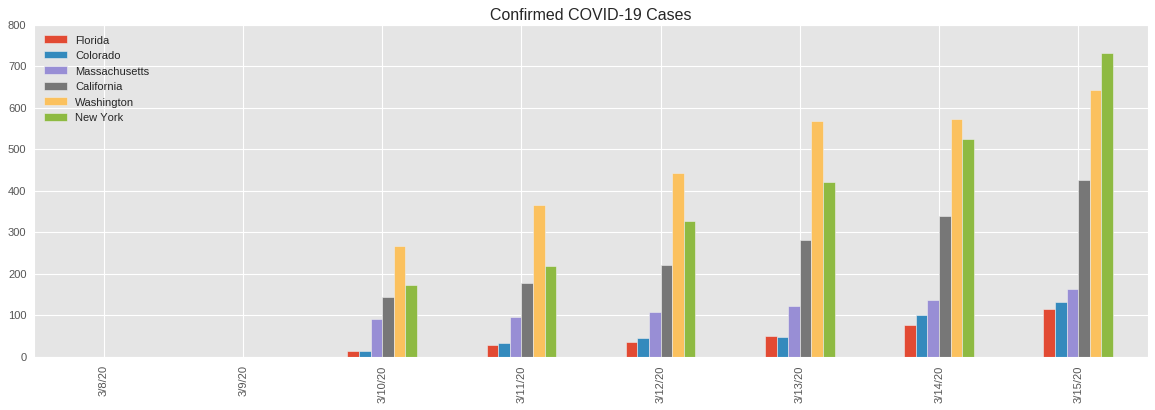

In [63]:
ax = by_state.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.show()

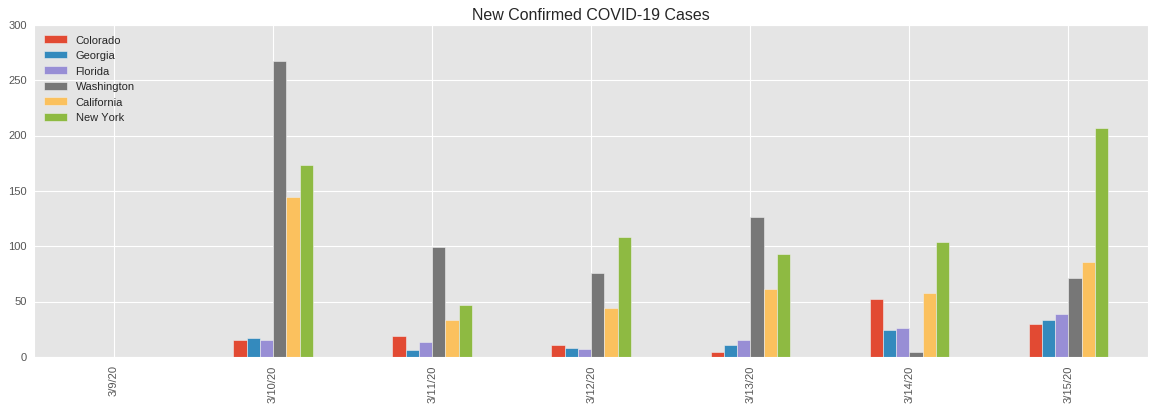

In [73]:
ax = new_daily_cases_US.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('New Confirmed COVID-19 Cases')
ax.legend(loc='upper left')

plt.show()

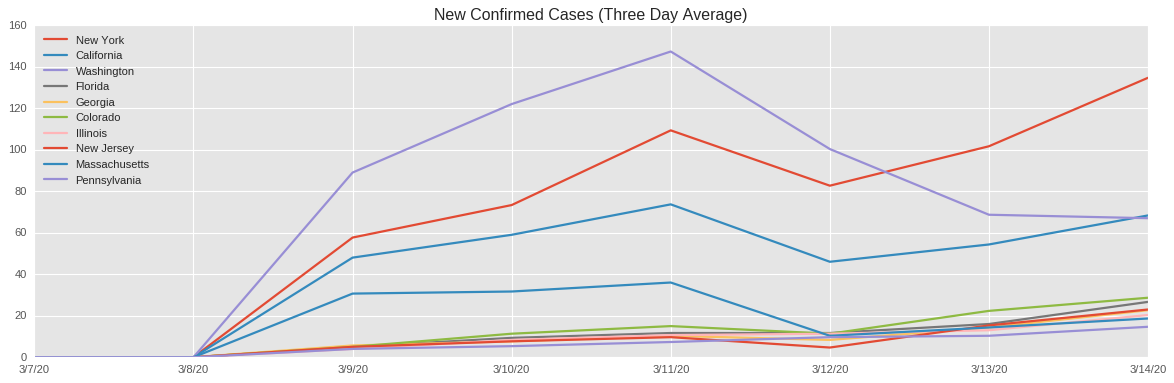

In [70]:
ax = new_daily_cases_US.rolling(3, center=True, axis=1).mean().iloc[:10, 44:].T.plot()

ax.legend(loc='upper left')
ax.set_title('New Confirmed Cases (Three Day Average)')

plt.show()

## Worldwide

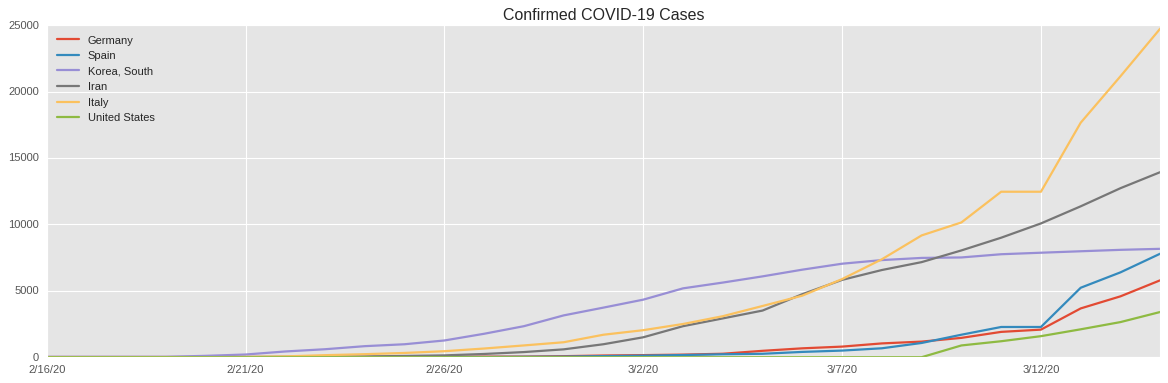

In [102]:
ax = by_country.iloc[:5, 25:][::-1].T.plot()


plt.plot(by_state.sum()[25:], label='United States')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.savefig('covid-by-country.png', dpi=300)
plt.show()

In [84]:
by_country[:30]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
country,,,,,,,,,,,,,,,,,,,,,
Italy,0,0,0,0,0,0,0,0,0,2,...,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747
Iran,0,0,0,0,0,0,0,0,0,0,...,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938
"Korea, South",1,1,2,2,3,4,4,4,4,11,...,6593,7041,7314,7478,7513,7755,7869,7979,8086,8162
Spain,0,0,0,0,0,0,0,0,0,0,...,400,500,673,1073,1695,2277,2277,5232,6391,7798
Germany,0,0,0,0,0,1,4,4,4,5,...,670,799,1040,1176,1457,1908,2078,3675,4585,5795
Switzerland,0,0,0,0,0,0,0,0,0,0,...,214,268,337,374,491,652,652,1139,1359,2200
Norway,0,0,0,0,0,0,0,0,0,0,...,108,147,176,205,400,598,702,996,1090,1221
Netherlands,0,0,0,0,0,0,0,0,0,0,...,128,188,265,321,382,503,503,804,959,1135
Sweden,0,0,0,0,0,0,0,0,0,1,...,101,161,203,248,355,500,599,814,961,1022
